In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import qiime2 as q2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
from skbio import TreeNode
from biom import load_table, Table

from featlib import Sculptor, load_mf
from featlib.extractor import abs_energy

Make the plot aesthetics homogeneous.

In [2]:
plt.style.use('seaborn-whitegrid')

We need to load three files, the OTU table, a phylogenetic tree corresponding to that table and a metadata mapping file. The metadata file must include a gradient column, in our case ``DAYS_SINCE_EPOCH`` (we convert this into a numeric column).


The table is rarefied at 4,000 sequences per sample, this could be changed but at this level we can keep a large number of subjects and samples per subject.

In [3]:
# rarefy before renaming
bt = load_table('jansson/otu-table.even4000.biom')

mf = load_mf('jansson/mapping-file.txt')

# we only keep the samples that have sequences in the table
mf = mf.loc[bt.ids()].copy()

tree = TreeNode.read('gg_13_8_otus/trees/97_otus.tree')

In [4]:
samples_to_keep = mf[mf.ibd_subtype.isin(['HC', 'CCD'])].index.tolist()

mf = mf.loc[samples_to_keep].copy()
bt = bt.filter(samples_to_keep, inplace=False)

mf['timepoint'] = pd.to_numeric(mf['timepoint'], errors='coerce')

mf['IBD'] = mf['ibd_subtype'].replace({'CCD': "Crohns",
                                       'HC': 'Healthy Controls'})
mf['HOST_SUBJECT_ID'] = mf['host_subject_id'].copy()

In [6]:
%%bash

mkdir -p roc-curves/gg-jansson/cached-matrices

cp jansson/unweighted-unifrac.full.txt roc-curves/gg-jansson/cached-matrices/
cp jansson/weighted-unifrac.full.txt roc-curves/gg-jansson/cached-matrices/

We've built a custom object that will handle alpha diversity, beta diversity and the creation of the microbial features. This object relies on the three objects described above and on two categories, one that identifies the subjects (``trajectories`` is set to ``HOST_SUBJECT_ID``) and one that identifies the ordering of the samples per subject (``gradient`` is set to ``DAYS_SINCE_EPOCH``).

This object will also take care of caching the distance matrices for the full dataset so that they are not computed at **every** iteration. Matrices will be saved under the `roc-curves/gg` directory, the name of the subfolder (that is `gg`), is determined by the `name` parameter in the constructor.

In [5]:
think = Sculptor(biom_table=bt, mapping_file=mf, tree=tree,
                 gradient='timepoint', trajectory='host_subject_id',
                 name='gg-jansson')

To see the effect of including more samples per subject we use the performance of a classifier, and we randomly select $N$ samples from all the subjects over $M$ iterations. At each iteration we train a random forests model, and at the end we compare the performance at different values of $N$.

We will create a receiver operating characteristic curve with the data for all the 100 iterations. The source code to create the plot was taken from [scikit-learn's documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html). Note that we set up the classifier to use 4 cores, which might not be a good idea depending on where you run this source.

/Users/yoshikivazquezbaeza/miniconda/envs/herfarth-ccfa-py3/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/yoshikivazquezbaeza/miniconda/envs/herfarth-ccfa-py3/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/yoshikivazquezbaeza/miniconda/envs/herfarth-ccfa-py3/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/yoshikivazquezbaeza/miniconda/envs/herfarth-ccfa-py3/lib/python3.5/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/yoshikivazquezbaeza/m

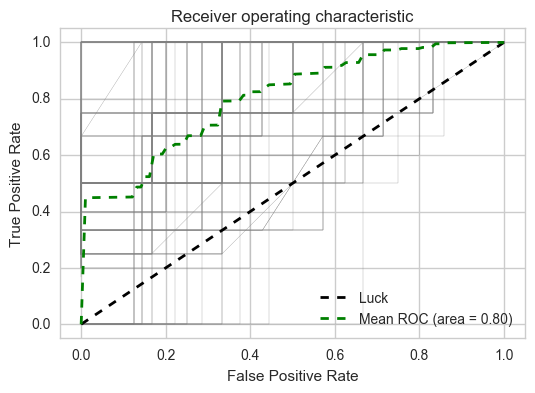

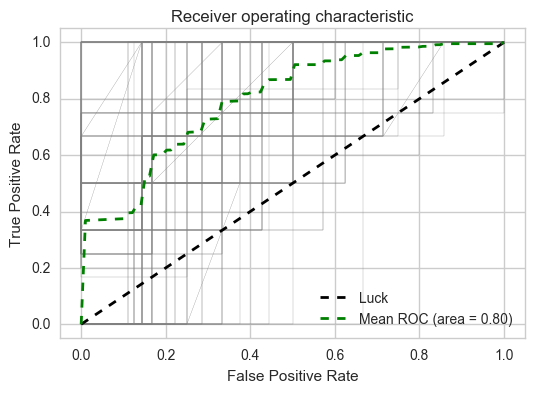

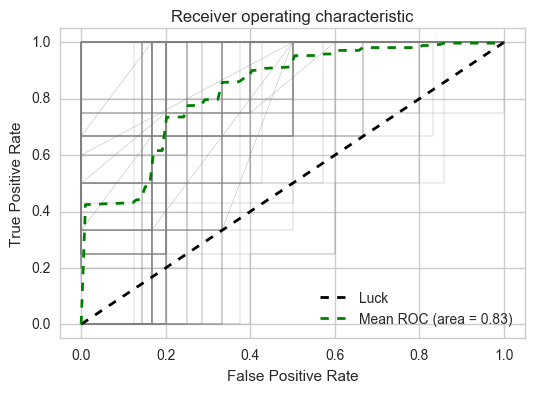

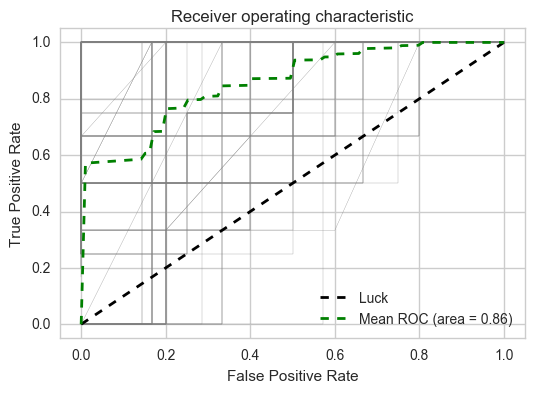

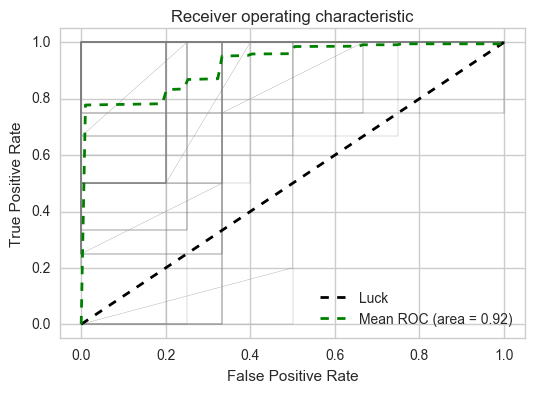

In [9]:
lw = 2

N = 100
for N_samples in range(0, 5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure()
    i = 0
    while i < N:
        ## BEGIN feature creation
        
        # zero samples means "traditional" classifier
        # with one sample per subject
        think.randomly_select(1 if N_samples == 0 else N_samples)

        # groups discovered by phylofactor
        features_to_keep = []
        for _, id_, md in think.biom_table.iter(axis='observation', dense=False):
            t = md['taxonomy']
            if (t[4].lower() == 'f__lachnospiraceae'
                or t[2].lower() == 'c__gammaproteobacteria'
                or t[2].lower() == 'c__betaproteobacteria'):
                features_to_keep.append(id_)

        # more than one sample
        if N_samples > 1:
            alpha = think.alpha_table(['faith_pd', 'chao1', 'brillouin_d'])
            beta = think.beta_table()
            features = think.microbes_over_time(ids=features_to_keep)
            
            # combine the data
            combined_features = pd.concat([features, alpha, beta], axis=1)

            # get a column with IBD status for all the subjects
            combined_features.dropna(axis=1, how='any', inplace=True)
            classes = think.mapping_file.groupby(['HOST_SUBJECT_ID', 'IBD'],
                                        as_index=False).aggregate(np.sum).set_index('HOST_SUBJECT_ID',
                                                                                    inplace=False)
            combined_features['IBD'] = classes['IBD']
        # one sample with our model
        elif N_samples == 1:
            alpha = think.alpha_table(['faith_pd', 'chao1', 'brillouin_d'], [abs_energy])
            features = think.biom_table.filter(ids_to_keep=features_to_keep, axis='observation')
            features = features.norm(inplace=False).to_dataframe().to_dense().T
            features['HOST_SUBJECT_ID'] = think.mapping_file['HOST_SUBJECT_ID']
            features['IBD'] = think.mapping_file['IBD']
            features.set_index('HOST_SUBJECT_ID', inplace=True)
            combined_features = pd.concat([features, alpha], axis=1)
        # one sample with only relative abundances
        elif N_samples == 0:
            combined_features = think.biom_table.norm(inplace=False).to_dataframe().to_dense().T
            combined_features['IBD'] = think.mapping_file['IBD']

        # get a list of the features without the labels
        no_ibd = combined_features.columns.tolist()
        no_ibd.remove('IBD')
        ## END feature creation

        X_train, X_test, Y_train, Y_test = train_test_split(combined_features[no_ibd],
                                                            combined_features['IBD'],
                                                            test_size=0.35)

        clf = RandomForestClassifier(n_estimators=500, n_jobs=4)
        probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1], pos_label='Healthy Controls')
        
        # skip any results with np.nan values as it means
        # the test/train split yieleded a bad selection
        if np.any(np.isnan(fpr)) or np.any(np.isnan(tpr)):
            continue 
        else:
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            plt.plot(fpr, tpr, lw=0.1*lw, color='gray')

            i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= N
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc-curves/%s/%d.samples.per.subject-%d.iterations.pdf' % (think.name, N_samples, N))